# Distinct element estimation using k-th min 

In the lecture, we studied the algorithm named Idealized $F_0$ estimation (slide 19). The algorithm uses a random hash function to map elements from the stream to float values between 0 and 1. Ultimately, it maintains the smallest hash value $V$ and outputs ${1\over V}-1$ as the estimate $\tilde{F}_0$ for the number of distinct elements.

This algorithm uses the idea that the expected value of the smallest hash value is $1\over F_0+1$, where $F_0$ is the number of distinct elements. In fact, we can generally use the $k$-th smallest hash value $V_k$ for $k=1,2,\dots$. We will use the results from exercise 4 to conduct experiments to see how different $k$ values affect the accuracy of your estimate.

[Optional]: Let m be the length of the stream. You can maintaining the k-th smallest element in an unsorted list in time $O(m\log k)$ using min heap, see https://docs.python.org/3/library/heapq.html. 

In [36]:
# Import packages needed.
import random, math
import numpy as np
import matplotlib.pyplot as plt

To test the effect of k, we must first implement a function that takes a data sequence, hash each element to a value between 0 and 1, and returns the k-th smallest hash value. Python has a built-in hash function hash() that takes any hashable object and returns an integer hash. To convert a hash value to a float, use modular the hash with a large int and divide by it, for instance, $MAXINT=2^{63}-1$.

In [37]:
import sys
MAXINT = sys.maxsize

In [38]:
def kth_smallest_hash_value(input_list, k):
#     Write your code here
    hash_values = []
    for element in input_list:
        hashed = hash(element) % MAXINT
        float_value = hashed / MAXINT
        hash_values.append(float_value)

    sorted_hash_values = sorted(hash_values)

    return sorted_hash_values[k-1]

Now let us test k values between 1 to 10. For each k, we will generate a list of 1000 random **strings** using ``str(random.uniform(0,100))``, and estimate its cardinality via the returned value from the function ``kth_smallest_hash_value`` you implemented. For each k, repeat this process 100 times and record the average and std of the estimates. Finally, generate a plot with error bars to show the relation between estimates and k values. Note that the std for small k can be very large, so you may need to set plt.ylim(-1000, 10000) to cap the y-axis for better visualization.

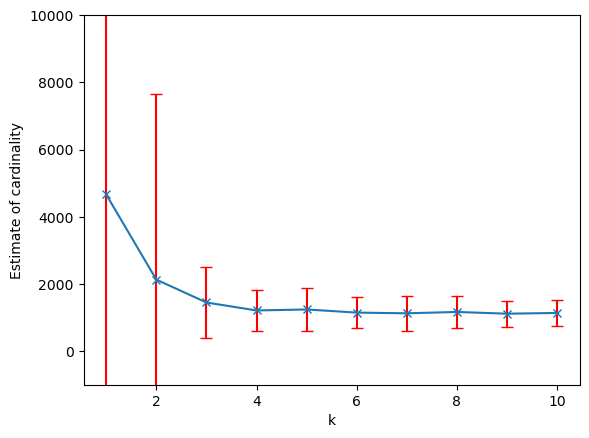

In [128]:
# Write your code here
k_values = list(range(1, 11))
num_trials = 100
num_elements = 1000
avg_estimates = []
std_estimates = []

for k in k_values:
    estimates = []
    for i in range(num_trials):
        data = [str(random.uniform(0, 100)) for j in range(num_elements)]   
        estimate = k / kth_smallest_hash_value(data, k) - 1
        estimates.append(estimate)
    avg_estimate = sum(estimates) / num_trials
    std_estimate = (sum((x - avg_estimate)**2 for x in estimates) / (num_trials - 1))**0.5
    avg_estimates.append(avg_estimate)
    std_estimates.append(std_estimate)
plt.errorbar(k_values, avg_estimates, yerr=std_estimates,ecolor='red',ls= '-', fmt='x',capsize = 4)
plt.xlabel('k')
plt.ylabel('Estimate of cardinality')
plt.ylim(-1000, 10000)
plt.show()

## The median trick useful technique (slide 13)

Please implement the function ``median_trick`` below. 

In [129]:
def median_trick(generator, expectation, var, eps, delta):
    '''
    Input:
        generator - a function that generates one sample from a distribution when being called.
        expectation - Expectation of the distribution
        var - Variance of the distribution
        eps - epsilon (accuracy parameter) as defined in slide 13
        delta - delta (confidence parameter) as defined in slide 13
    Output:
        estimated value Q
    '''
    # Write your code here
    t = int(np.ceil(np.log(1/delta)))
    k = int(np.ceil(var/(eps**2 * expectation**2)))
    estimates = []
    
    for i in range(t):
        samples = [generator() for i in range(k)]
        median = np.median(samples)
        estimates.append(median)
    q_hat = np.median(estimates)
    return q_hat

Now we want to test the function with the following idea. Assume Q=2. The unbiased estimator, X of Q, generates estimates that follow a normal distribution with variance equal to 1. The generator for X is already given below as ``normal_generator``. Please generate two plots below. 

- Set eps=0.1, and test how the delta affects the estimates. Range delta in [1e-6, 1e-4, 1e-3, 0.01, 0.1]; repeat the estimation 100 times for each delta value. Generate a plot with std as error bars to show how the average estimates change as the delta changes.

- Set delta=0.1, and test how the epsilon affects the estimates. Range epsilon in [0.01, 0.02, 0.05, 0.1, 0.2]; repeat the estimation 100 times for each epsilon value. Generate a plot with std as error bars to show how the average estimates change as the epsilon changes.

In [137]:
# Don't change
def normal_generator():
    return np.random.normal(2,1)

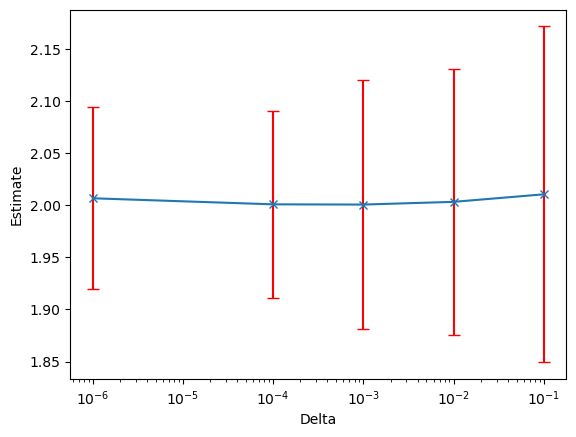

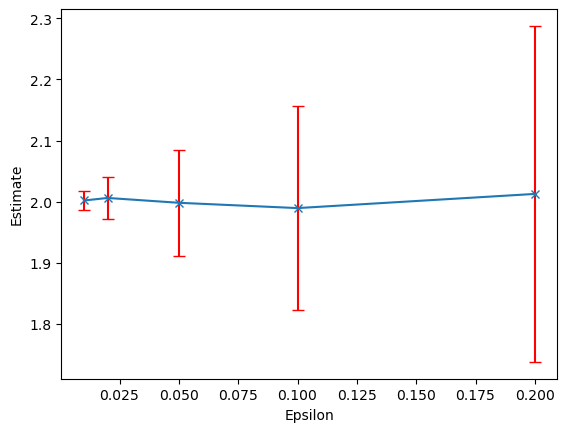

In [132]:
eps = 0.1
deltas = [1e-6, 1e-4, 1e-3, 0.01, 0.1]
estimates = []
stds = []
for delta in deltas:
    delta_estimates = []
    for i in range(100):
        q_hat = median_trick(normal_generator, 2, 1, eps, delta)
        delta_estimates.append(q_hat)
    estimates.append(np.mean(delta_estimates))
    stds.append(np.std(delta_estimates))

plt.errorbar(deltas, estimates, yerr=stds,ecolor='red',ls= '-', fmt='x', capsize=4)
plt.xscale('log')
plt.xlabel('Delta')
plt.ylabel('Estimate')
plt.show()

delta = 0.1
epsilons = [0.01, 0.02, 0.05, 0.1, 0.2]
estimates = []
stds = []
for eps in epsilons:
    eps_estimates = []
    for i in range(100):
        q_hat = median_trick(normal_generator, 2, 1, eps, delta)
        eps_estimates.append(q_hat)
    estimates.append(np.mean(eps_estimates))
    stds.append(np.std(eps_estimates))

plt.errorbar(epsilons, estimates, yerr=stds,ecolor='red',ls= '-', fmt='x', capsize=4)
plt.xlabel('Epsilon')
plt.ylabel('Estimate')
plt.show()

## Morris Algorithm (slide 45)

Morris algorithm maintains a counter c that, for every element in the stream, itself increments by 1 with probability $1\over 2^c$. In the end, it outputs an estimate as $2^c-1$.

In this section, we will change the base of this counter (slide 51). Instead of using 2 only, we use any base $1+\alpha$. We now increase the counter c with probability $1\over (1+\alpha)^c$. First, let us implement the function ``morris_update_base_alpha`` below. **This function is called whenever we see an element from the stream to update the counter.**

In [125]:
def morris_update_base_alpha(counter, alpha):
    '''
    Input:
        counter - current value of counter c
        alpha - as defined in slide 51 alpha
    Output:
        updated value of counter c
    '''
    if random.random() < 1 / ((1 + alpha) ** counter):
        return counter + 1
    else:
        return counter

Now let us test the function with the edge list file "soc-hamsterster.edges" in the same folder. Reading the file line by line in python can generate a stream of strings. Counting the number of strings/lines in this file tells us the number of edges of this "soc-hamsterster" graph. Let us try different alpha values ranging from 2 to 9. Again, for each alpha, estimate the number of lines in the edge list file using the morris algorithm (the key component of which is ``morris_update_base_alpha``), and repeat this 100 times. Besides, check how many bits are needed to maintain the counter via ``math.ceil(math.log(counter, 2))`` at the end of each estimation. Finally, generate two plots with std as error bars to show 

- How the average estimate changes as the alpha value increases. 
- How the space usage (in bits) changes as the alpha value increases.

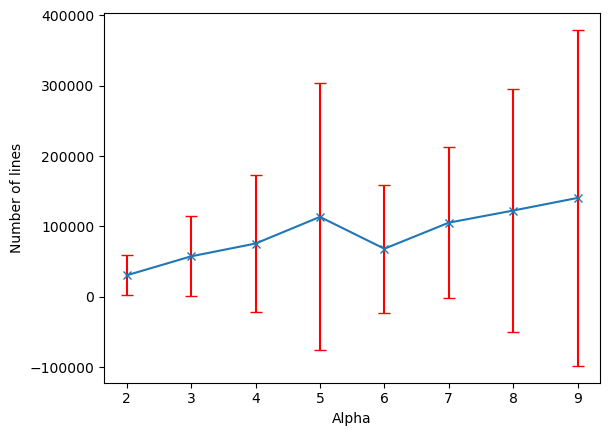

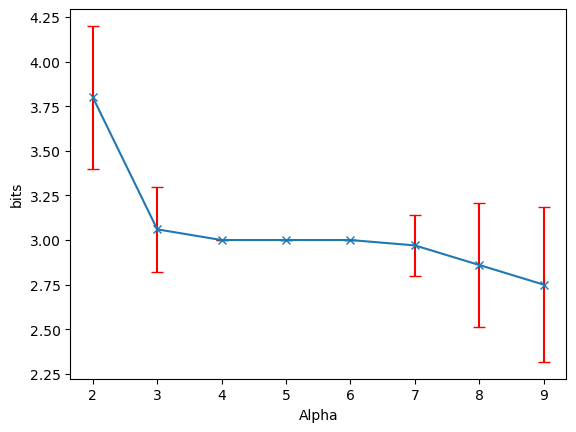

In [138]:
with open('soc-hamsterster.edges') as f:
    stream = f.readlines()

n = len(stream)

alphas = [2, 3, 4, 5, 6, 7, 8, 9]
repeats = 100

estimates = [[] for m in alphas]
spaces = [[] for m in alphas]

for i, alpha in enumerate(alphas):
    for j in range(repeats):
        counter = 0
        for line in stream:
            counter = morris_update_base_alpha(counter, alpha)
        estimate = (1 + alpha) ** counter - 1
        space = math.ceil(math.log(counter, 2))
        estimates[i].append(estimate)
        spaces[i].append(space)

plt.errorbar(alphas, [np.mean(x) for x in estimates], yerr=[np.std(x) for x in estimates],ecolor='red',ls= '-', fmt='x', capsize=4)
plt.xlabel('Alpha')
plt.ylabel('Number of lines')
plt.show()

plt.errorbar(alphas, [np.mean(x) for x in spaces], yerr=[np.std(x) for x in spaces],ecolor='red',ls= '-', fmt='x', capsize=4)
plt.xlabel('Alpha')
plt.ylabel('bits')
plt.show()